<a href="https://colab.research.google.com/github/QLi007/Predict-the-stock-price-with-Double-DQN/blob/main/Copy_of_pytorch_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!wget -O data.csv "https://drive.google.com/uc?export=download&id=18nfd3MAayQGagc71ml7Ysd7AG_iIplbe" 
!wget -O data.csv "https://drive.google.com/uc?export=download&id=1SV7GEmBxJCMi3UQwKhDo7PYwUAX-226v" #tsla, 2021.12.7

--2021-05-02 05:19:41--  https://drive.google.com/uc?export=download&id=18nfd3MAayQGagc71ml7Ysd7AG_iIplbe
Resolving drive.google.com (drive.google.com)... 108.177.97.139, 108.177.97.138, 108.177.97.102, ...
Connecting to drive.google.com (drive.google.com)|108.177.97.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0c-9c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/324mvss555qohuhrs52fiok5ljc8n1et/1619932725000/07025506278222432509/*/18nfd3MAayQGagc71ml7Ysd7AG_iIplbe?e=download [following]
--2021-05-02 05:19:42--  https://doc-0c-9c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/324mvss555qohuhrs52fiok5ljc8n1et/1619932725000/07025506278222432509/*/18nfd3MAayQGagc71ml7Ysd7AG_iIplbe?e=download
Resolving doc-0c-9c-docs.googleusercontent.com (doc-0c-9c-docs.googleusercontent.com)... 74.125.204.132, 2404:6800:4008:c04::84
Connecting to doc-0c-9c-docs.googleusercontent.com (doc-0c

In [ ]:
import numpy as np
import random
from collections import deque
import gym
from gym import spaces
from types import SimpleNamespace
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F
from torch.autograd import Variable
import csv
import math
import matplotlib.pyplot as plt

EPISILON = 0.1
CUDA = True

In [ ]:
header = []
header_dict = {}
data = []
X = []
with open("data.csv", "r") as f:
    reader = csv.reader(f)
    rows = []
    for row in reader:
        rows.append(row)
    header = rows[0]
    header_dict = dict(zip(header,range(len(header))))
    # ignore first two row
    # discard data before 2009
    for i in range(100, len(rows)):
        indicators = [float(v) for v in rows[i][1:]]
        data.append([rows[i][0]] + indicators)
        X.append(indicators)

# Preprocessing
print(header)
diff = ['ema26', 'ema12', 'frac_close', 'frac_value']
X = np.array(X)
price = X[1:, header_dict['frac_close']-1].copy()
for df in diff:
    X[1:, header_dict[df]-1] -= X[:-1, header_dict[df]-1]
X = X[1:, ]

split = int(X.shape[0] * 0.7)
# split = 100
X_train = X[:split]
X_test = X[split:]

print(data[split][0], X_train.shape, X_test.shape)

WINDOW = 20
LENGTH = 300

['Date', 'ema26', 'ema12', 'diff', 'dea', 'macd', 'numindex', 'hlc', 'frac_type', 'frac_close', 'frac_value', 'tbc_value', 'macd_d', 'Volume_d', 'dev_macd']
12/18/2015 (590, 14) (254, 14)


In [ ]:
class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

In [ ]:

class Stock(gym.Env):
  def __init__(self, data, eval = False):
    self.data = np.array(data)
    self.window_size = WINDOW
    # 2 actions: 0.Sell 1 share, 1. Buy 1 share #, 2. Sell 1 share
    self.action_space = spaces.Discrete(2)
    # Observation
    self.observation_space = SimpleNamespace(shape=(self.window_size, len(data[0])+1))
    self.current_hold = 0
    self.eval = eval
    self.pos = self.window_size
    self.end = len(data)
    self._state = np.zeros(self.observation_space.shape)

  def getWindow(self):
    window = self.data[self.pos-self.window_size:self.pos, :]
    return window

  def reset(self):
    self.pos = self.window_size
    if not self.eval:
      # Start at a random position
      self.pos += np.random.randint(self.data.shape[0] - LENGTH - self.window_size -1, size=1)[0]
      self.end = self.pos + LENGTH
    
    window = self.getWindow()
    self._state = np.hstack([window, np.zeros((self.window_size, 1))])
    #self._state[:-1] = window.flatten()
    self._state[-1, -1] = 0
    self.current_hold = 0
    self._episode_ended = False
    return self._state.copy()

  def step(self, action):

    if self._episode_ended:
        # The last action ended the episode. Ignore the current action and start
        # a new episode.
        return self.reset()
    
    # Calculate reward based on Close price
    current_hold = self._state[-1, -1]
    reward = self.data[self.pos-1, 8] if current_hold else 0

    self.pos += 1
    window = self.getWindow()
    #self._state[:-1] = window.flatten()
    self._state[:-1] = self._state[1:]
    self._state[:, :-1] = window

    if action == 1:
        self._state[-1] = 1
    elif action == 0:
        self._state[-1] = 0
    else:
      raise ValueError('`action` should be 0 or 1.')
    
    if self.pos >= self.end:
        self._episode_ended = True
    
    return self._state.copy(), reward, self._episode_ended, None


In [ ]:
class DQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(DQN, self).__init__()
        self.input_shape = input_shape
        self.num_actions = num_actions
        self.fc1 = nn.Linear(input_shape[1], 40)
        self.lstm = nn.LSTM(40, 40, batch_first = True)
        self.fc2 = nn.Linear(40, 20)
        self.fc3 = nn.Linear(20, num_actions)
        '''
        self.layers = nn.Sequential(
            nn.Linear(input_shape[0], 40),
            nn.ReLU(),
            nn.Linear(40, 20),
            nn.ReLU(),
            nn.Linear(20, 1)
        )
        '''
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        output, (hn, cn) = self.lstm(x)
        x = F.relu(self.fc2(output[:, -1, :]))
        #x = torch.sigmoid(self.fc3(x))
        x = self.fc3(x)
        return x
        #return torch.sigmoid(self.layers(x))
    
    def act(self, state, epsilon, cuda = False):
        if random.random() > epsilon:
            with torch.no_grad():
                state = Variable(torch.FloatTensor(state).unsqueeze(0))
            if cuda:
                state = state.cuda()
            # print(state)
            q_value = self.forward(state)
            action  = q_value.max(1)[1].data[0]
        else:
            action = random.randrange(self.num_actions)
        return action

In [ ]:
def eval(data, price, model, plot = False):
    eval_env = Stock(data, True)
    state = eval_env.reset()
    episode_reward = 0
    t = 0
    states_buy, states_sell = [], []
    last = -1
    while True:
        action = model.act(state, -1, CUDA)
        if action != last:
            if action == 1:
                states_buy.append(t)
            elif action == 0:
                states_sell.append(t)
        
        last = action
        t += 1
        next_state, reward, done, _ = eval_env.step(action)
        state = next_state
        episode_reward += reward
        if done:
            break

    if plot:
        fig = plt.figure(figsize = (15,5))
        plt.plot(price, color='r', lw=2.)
        plt.plot(price, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
        plt.plot(price, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
        plt.title('total gains %f' % (episode_reward))
        plt.legend()
        plt.show()

    return episode_reward


In [ ]:
def train(data):
    env = Stock(data)
    num_step = 100000
    batch_size = 64
    gamma = 0.8
    USE_CUDA = CUDA
    target_episodes = 500

    epsilon_start = 1.0
    epsilon_final = 0.1
    epsilon_decay = 50
    epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

    current_model = DQN(env.observation_space.shape, env.action_space.n)
    target_model  = DQN(env.observation_space.shape, env.action_space.n)
    saved_model   = DQN(env.observation_space.shape, env.action_space.n)

    if USE_CUDA:
        current_model = current_model.cuda()
        target_model  = target_model.cuda()
        saved_model   = saved_model.cuda()
        
    optimizer = optim.Adam(current_model.parameters(), lr=0.0001)

    replay_buffer = ReplayBuffer(100000)

    def update_target(current_model, target_model):
        target_model.load_state_dict(current_model.state_dict())

    update_target(current_model, target_model)

    def compute_td_loss(batch_size):
        state, action, reward, next_state, done = replay_buffer.sample(batch_size)

        state      = Variable(torch.FloatTensor(np.float32(state)))
        next_state = Variable(torch.FloatTensor(np.float32(next_state)))
        action     = Variable(torch.LongTensor(action))
        reward     = Variable(torch.FloatTensor(reward))
        done       = Variable(torch.FloatTensor(done))

        if USE_CUDA:
            state = state.cuda()
            next_state = next_state.cuda()
            action = action.cuda()
            reward = reward.cuda()
            done = done.cuda()

        q_values      = current_model(state)
        next_q_values = current_model(next_state)
        next_q_state_values = target_model(next_state) 

        q_value       = q_values.gather(1, action.unsqueeze(1)).squeeze(1) 
        next_q_value = next_q_state_values.gather(1, torch.max(next_q_values, 1)[1].unsqueeze(1)).squeeze(1)
        expected_q_value = reward + gamma * next_q_value * (1 - done)
        
        #loss = (q_value - Variable(expected_q_value.data)).pow(2).mean()
        # Compute Huber loss
        criterion = nn.SmoothL1Loss()
        loss = criterion(q_value, expected_q_value)
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        return loss

    state = env.reset()
    all_rewards = []
    episode_reward = 0
    episode = 0
    iteration = 0

    print("Start training...")
    best_test = 0
    best_episode = 0
    while episode <= target_episodes:
        # epsilon = epsilon_by_frame(episode)
        epsilon = 0.1
        action = current_model.act(state, epsilon, USE_CUDA)

        next_state, reward, done, _ = env.step(action)
        replay_buffer.push(state, action, reward, next_state, done)
        state = next_state
        episode_reward += reward
        
        if len(replay_buffer) > batch_size:
            loss = compute_td_loss(batch_size) 
            if iteration % 500 == 0:
                print("Loss %.2f" % loss)

        if iteration % 10 == 0:
            update_target(current_model, target_model)

        iteration += 1

        if done:
            episode += 1
            state = env.reset()
            all_rewards.append(episode_reward)
            if episode % 10 == 0:
                print("Evaluate")
                # eval_reward = eval(data, price[WINDOW-1:split], current_model, True)
                test_reward = eval(X_test, price[split+WINDOW-1:], current_model, True)
                if test_reward > best_test:
                    best_test = test_reward
                    update_target(current_model, saved_model)
                    best_episode = episode
                print("Episode %d, Reward %.2f, Eval Reward %.2f, Epsilon %.4f" 
                    % (episode, episode_reward, test_reward, epsilon))
            episode_reward = 0
    print(best_episode)
    return current_model, saved_model, all_rewards

Start training...
Loss 15.36
Loss 13.77
Loss 9.84
Loss 7.04
Loss 7.40
Evaluate


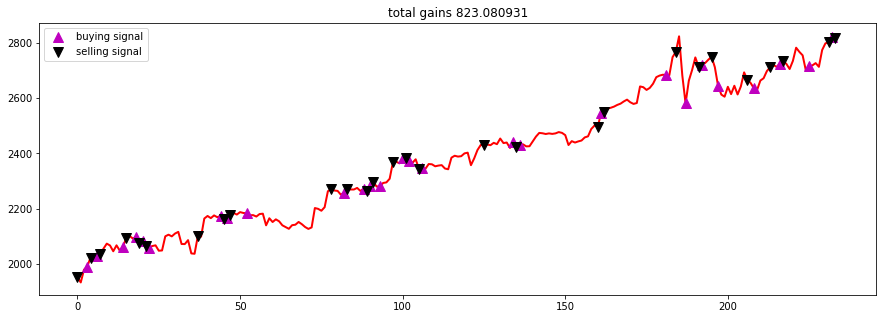

Episode 10, Reward 1010.30, Eval Reward 823.08, Epsilon 0.1000
Loss 6.52
Loss 7.24
Loss 2.80
Loss 6.10
Loss 3.88
Loss 3.27
Evaluate


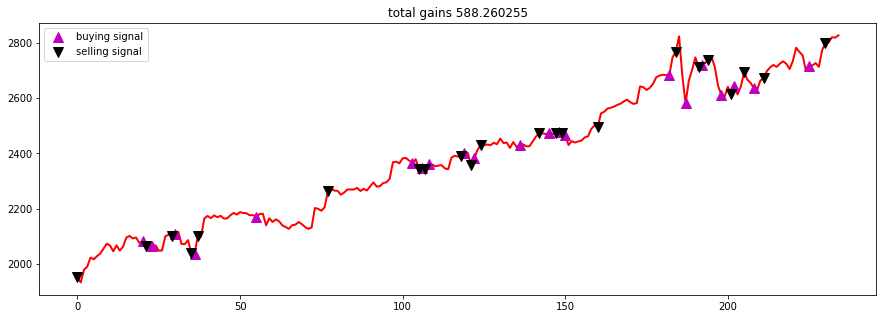

Episode 20, Reward 1442.73, Eval Reward 588.26, Epsilon 0.1000
Loss 3.94
Loss 5.14
Loss 2.84
Loss 3.00
Loss 2.68
Loss 2.01
Evaluate


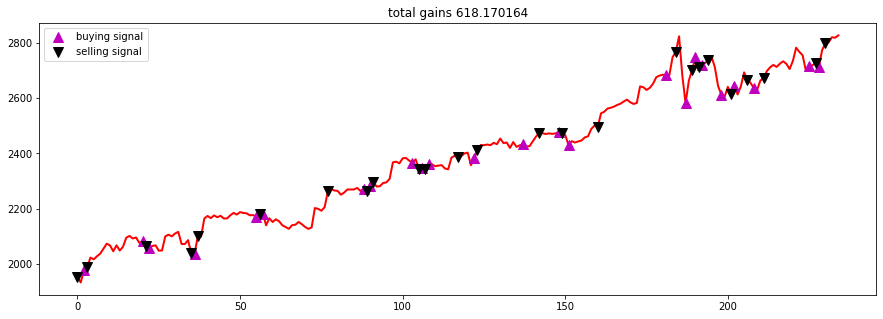

Episode 30, Reward 1235.07, Eval Reward 618.17, Epsilon 0.1000
Loss 3.41
Loss 3.39
Loss 3.06
Loss 3.32
Loss 3.33
Loss 1.81
Evaluate


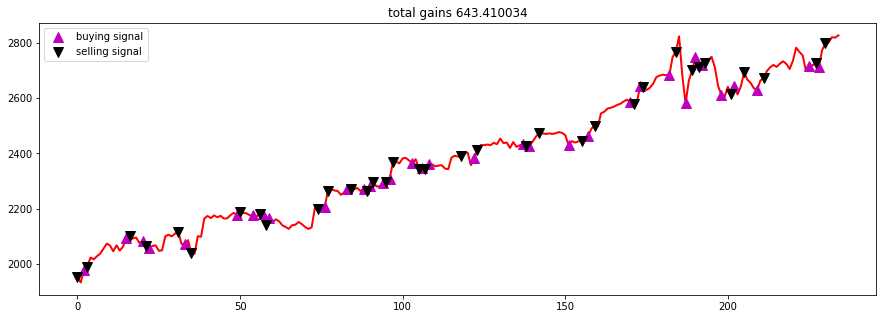

Episode 40, Reward 1178.59, Eval Reward 643.41, Epsilon 0.1000
Loss 1.79
Loss 2.35
Loss 1.50
Loss 1.74
Loss 1.66
Loss 1.65
Evaluate


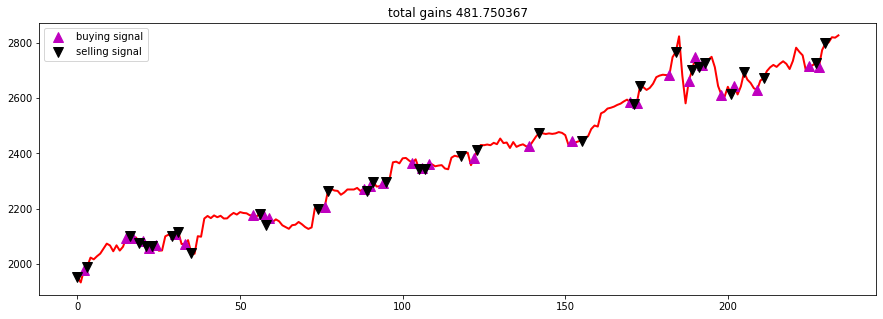

Episode 50, Reward 1321.03, Eval Reward 481.75, Epsilon 0.1000
Loss 3.43
Loss 4.31
Loss 2.44
Loss 2.28
Loss 1.65
Loss 3.97
Evaluate


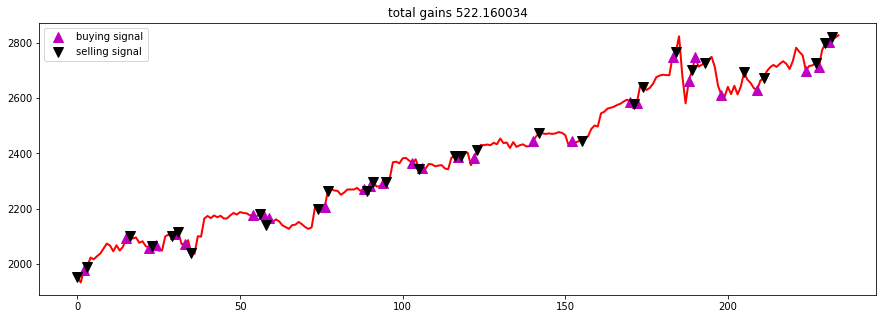

Episode 60, Reward 1241.78, Eval Reward 522.16, Epsilon 0.1000
Loss 3.34
Loss 1.61
Loss 1.15
Loss 3.23
Loss 0.95
Loss 3.64
Evaluate


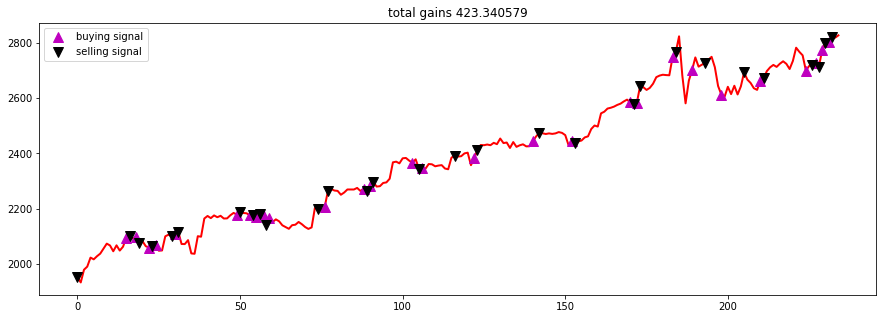

Episode 70, Reward 1372.18, Eval Reward 423.34, Epsilon 0.1000
Loss 0.65
Loss 2.03
Loss 3.34
Loss 2.28
Loss 2.02
Loss 1.89
Evaluate


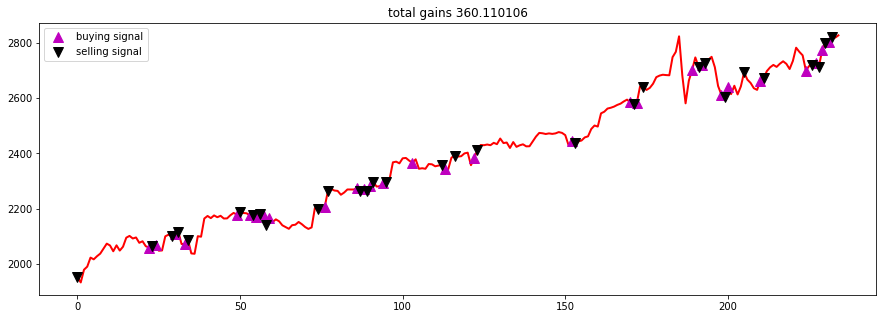

Episode 80, Reward 1270.95, Eval Reward 360.11, Epsilon 0.1000
Loss 1.93
Loss 3.65
Loss 2.04
Loss 0.75
Loss 2.61
Loss 0.93
Evaluate


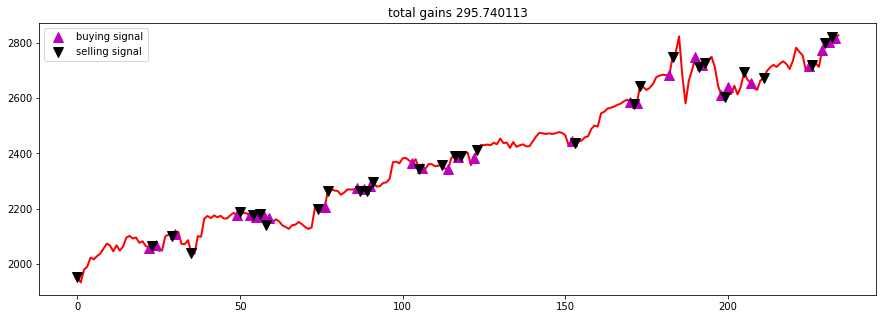

Episode 90, Reward 1382.58, Eval Reward 295.74, Epsilon 0.1000
Loss 1.31
Loss 3.35
Loss 1.49
Loss 2.26
Loss 4.83
Loss 1.64
Evaluate


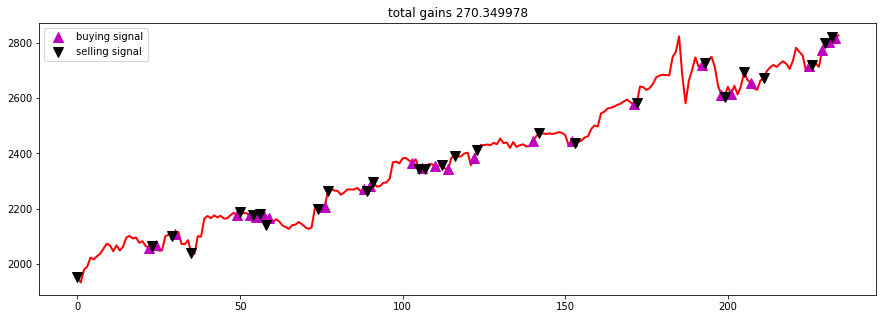

Episode 100, Reward 1391.28, Eval Reward 270.35, Epsilon 0.1000
Loss 2.01
Loss 2.29
Loss 2.06
Loss 2.41
Loss 1.95
Loss 2.49
Evaluate


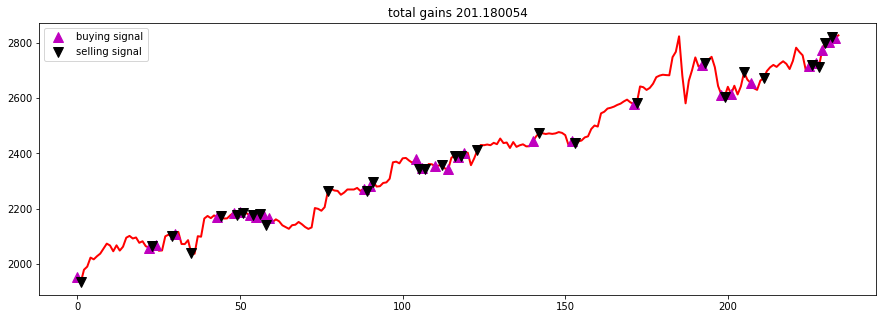

Episode 110, Reward 1469.78, Eval Reward 201.18, Epsilon 0.1000
Loss 1.13
Loss 2.89
Loss 2.04
Loss 1.76
Loss 2.41
Loss 3.15
Evaluate


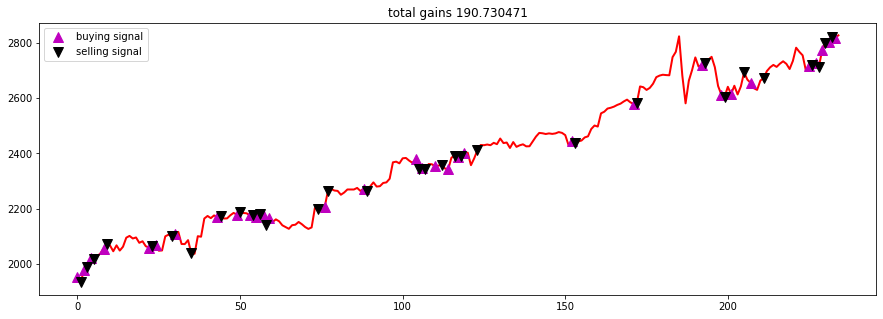

Episode 120, Reward 1542.18, Eval Reward 190.73, Epsilon 0.1000
Loss 1.88
Loss 1.79
Loss 0.98
Loss 2.32
Loss 1.89
Loss 2.09
Evaluate


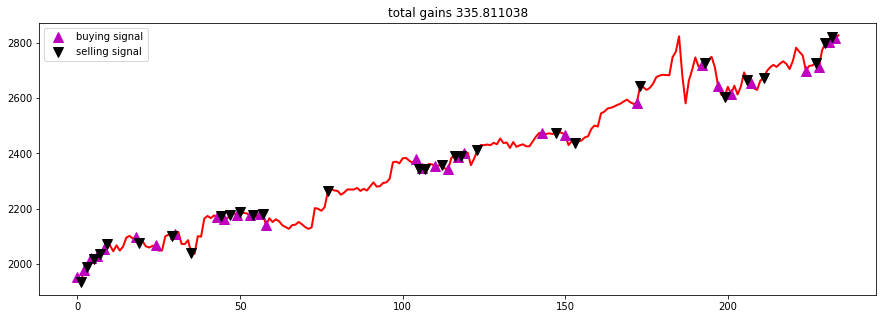

Episode 130, Reward 1455.42, Eval Reward 335.81, Epsilon 0.1000
Loss 4.79
Loss 1.54
Loss 3.16
Loss 2.06
Loss 0.72
Loss 0.49
Evaluate


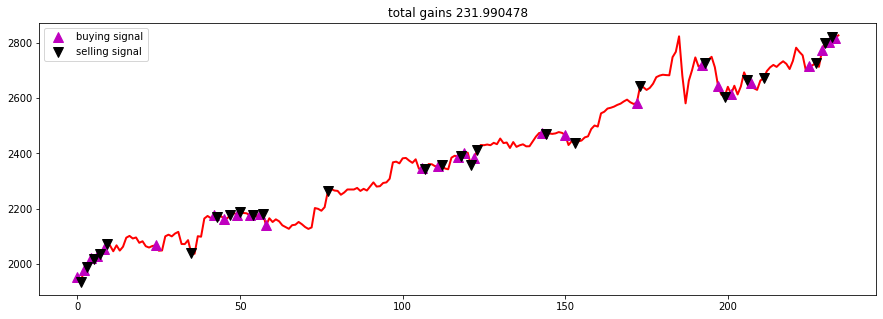

Episode 140, Reward 1435.49, Eval Reward 231.99, Epsilon 0.1000
Loss 2.09
Loss 2.45
Loss 1.87
Loss 1.65
Loss 0.57
Loss 1.66
Evaluate


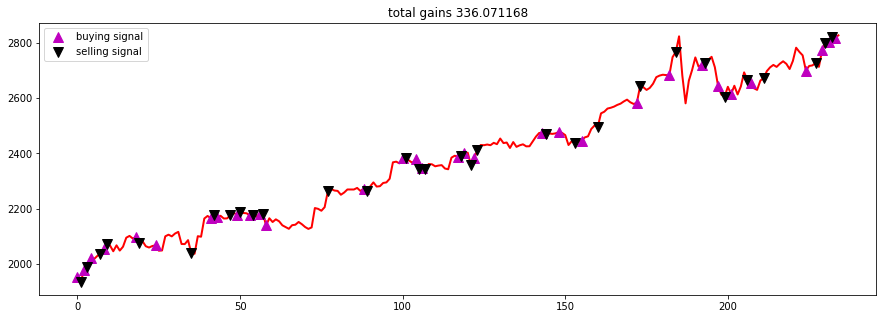

Episode 150, Reward 1808.85, Eval Reward 336.07, Epsilon 0.1000
Loss 0.82
Loss 2.15
Loss 1.02
Loss 1.18
Loss 1.78
Loss 1.60
Evaluate


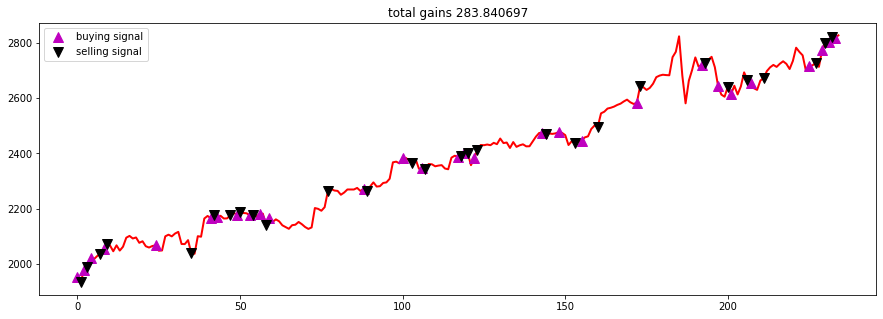

Episode 160, Reward 1621.96, Eval Reward 283.84, Epsilon 0.1000
Loss 2.55
Loss 1.25
Loss 0.52
Loss 2.55
Loss 1.54
Loss 3.05
Evaluate


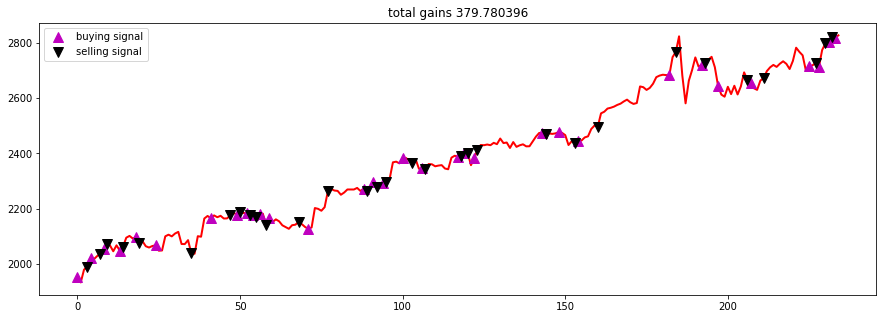

Episode 170, Reward 1410.47, Eval Reward 379.78, Epsilon 0.1000
Loss 0.78
Loss 1.58
Loss 1.40
Loss 1.22
Loss 1.17
Loss 1.06
Evaluate


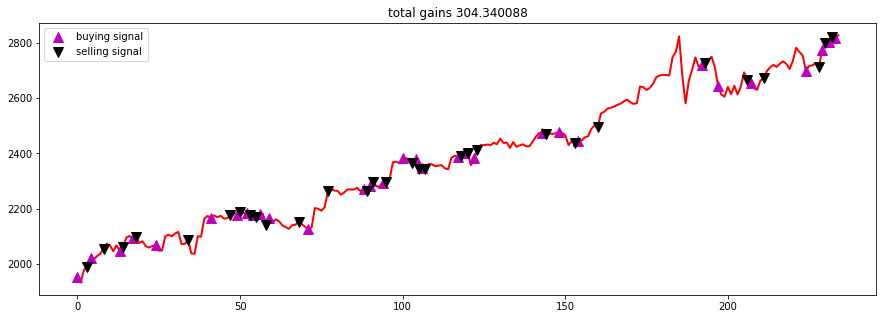

Episode 180, Reward 1682.29, Eval Reward 304.34, Epsilon 0.1000
Loss 0.93
Loss 2.23
Loss 1.64
Loss 2.18
Loss 1.12
Loss 2.28
Evaluate


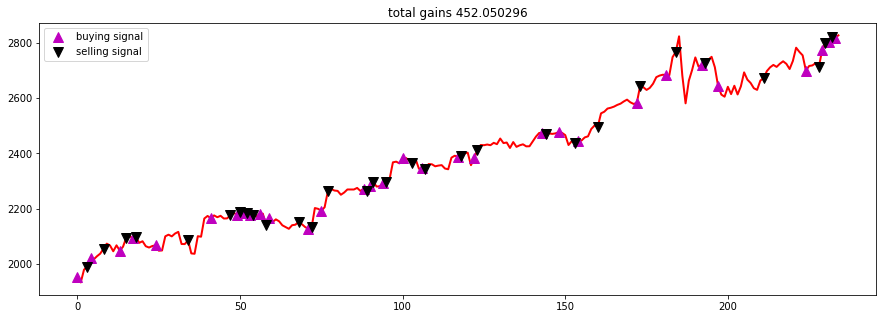

Episode 190, Reward 1531.87, Eval Reward 452.05, Epsilon 0.1000
Loss 2.15
Loss 1.50
Loss 0.88
Loss 0.83
Loss 2.07
Loss 1.77
Evaluate


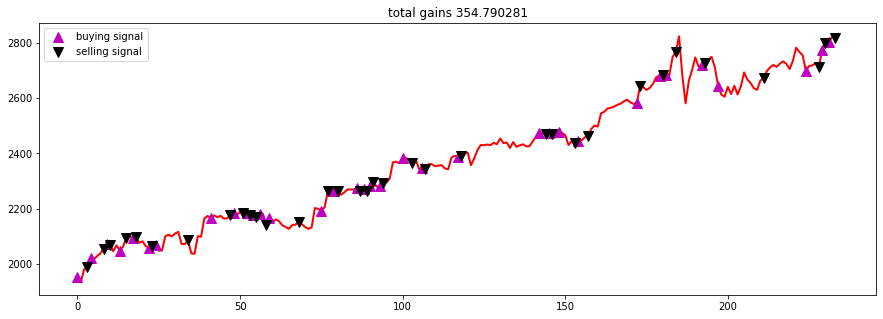

Episode 200, Reward 1710.20, Eval Reward 354.79, Epsilon 0.1000
Loss 1.16
Loss 0.85
Loss 0.55
Loss 1.80
Loss 1.94
Loss 2.96
Evaluate


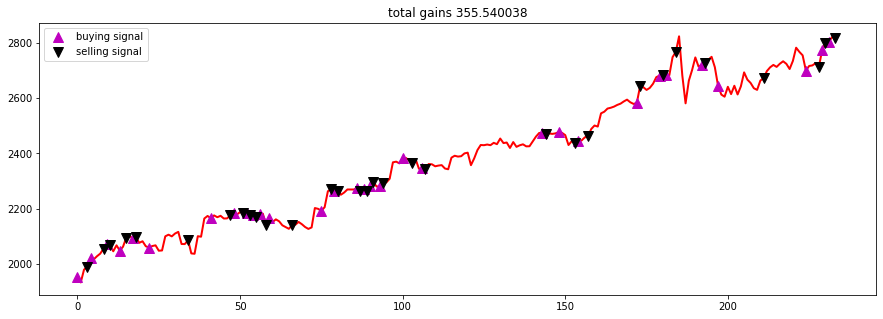

Episode 210, Reward 1814.22, Eval Reward 355.54, Epsilon 0.1000
Loss 1.18
Loss 1.71
Loss 0.61
Loss 2.74
Loss 0.34
Loss 0.66
Evaluate


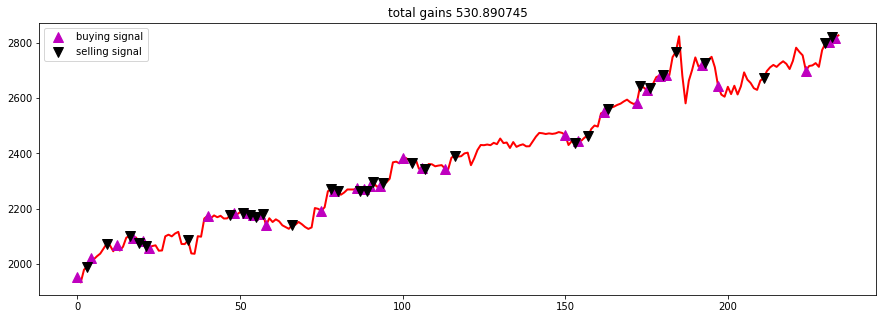

Episode 220, Reward 1719.13, Eval Reward 530.89, Epsilon 0.1000
Loss 0.66
Loss 1.07
Loss 1.29
Loss 1.24
Loss 1.41
Loss 1.43
Evaluate


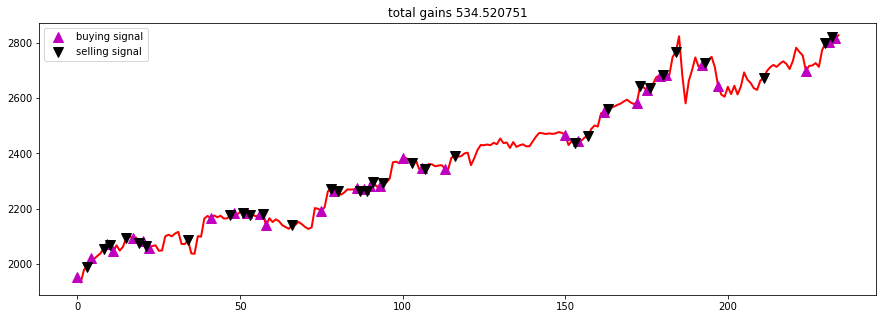

Episode 230, Reward 1647.82, Eval Reward 534.52, Epsilon 0.1000
Loss 2.45
Loss 1.71
Loss 1.42
Loss 1.30
Loss 1.54
Loss 1.14
Evaluate


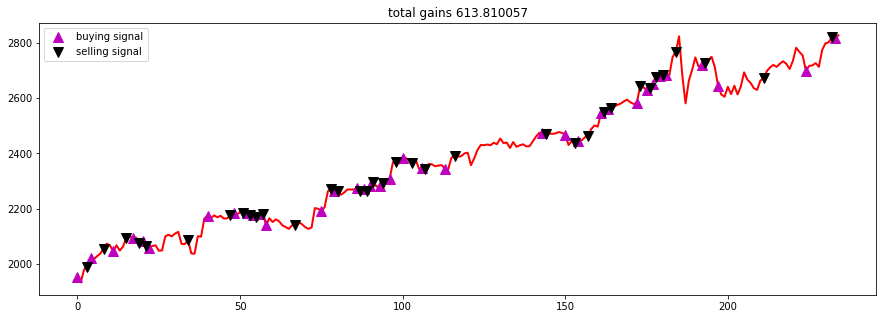

Episode 240, Reward 1968.03, Eval Reward 613.81, Epsilon 0.1000
Loss 1.00
Loss 0.83
Loss 0.82
Loss 0.73
Loss 0.57
Loss 1.17
Evaluate


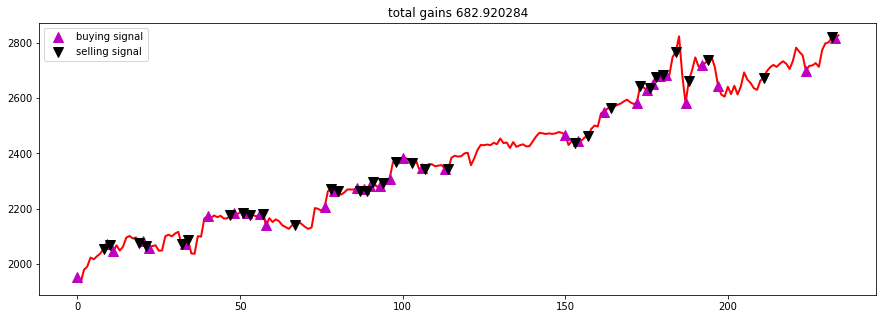

Episode 250, Reward 1825.95, Eval Reward 682.92, Epsilon 0.1000
Loss 0.55
Loss 0.69
Loss 1.11
Loss 0.99
Loss 0.86
Loss 2.02
Evaluate


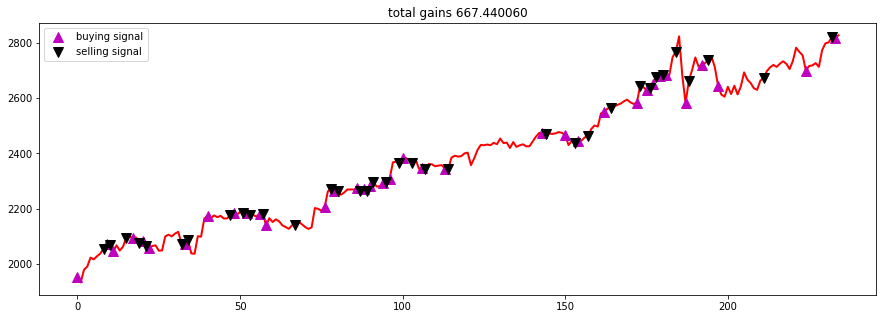

Episode 260, Reward 1854.97, Eval Reward 667.44, Epsilon 0.1000
Loss 0.70
Loss 0.93
Loss 0.96
Loss 0.23
Loss 0.43
Loss 0.59
Evaluate


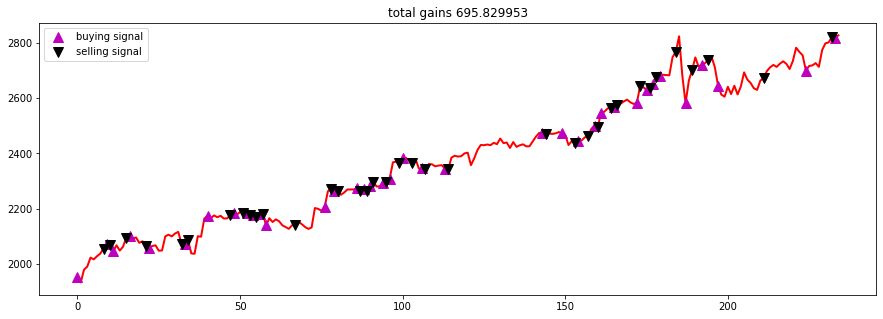

Episode 270, Reward 1723.33, Eval Reward 695.83, Epsilon 0.1000
Loss 0.52
Loss 1.23
Loss 0.65
Loss 0.54
Loss 0.55
Loss 0.64
Evaluate


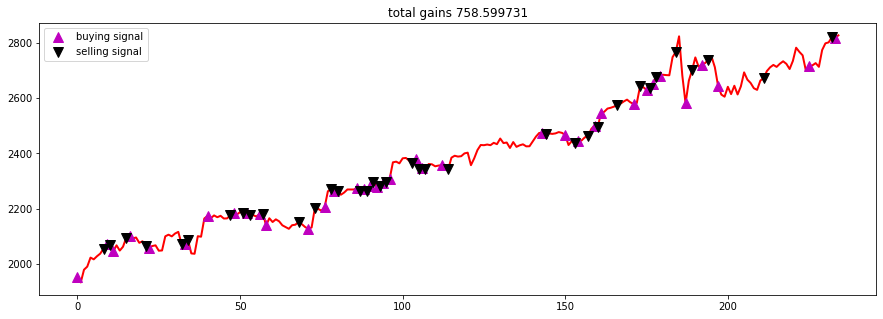

Episode 280, Reward 2034.87, Eval Reward 758.60, Epsilon 0.1000
Loss 0.22
Loss 0.95
Loss 0.78
Loss 0.63
Loss 0.70
Loss 2.10
Evaluate


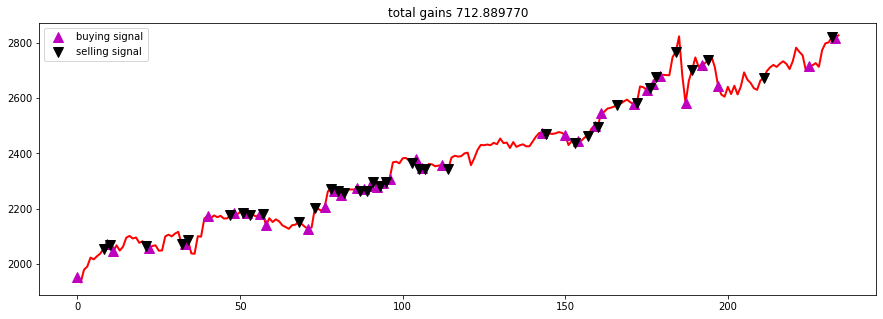

Episode 290, Reward 1753.20, Eval Reward 712.89, Epsilon 0.1000
Loss 1.51
Loss 1.22
Loss 0.77
Loss 1.26
Loss 0.50
Loss 0.74
Evaluate


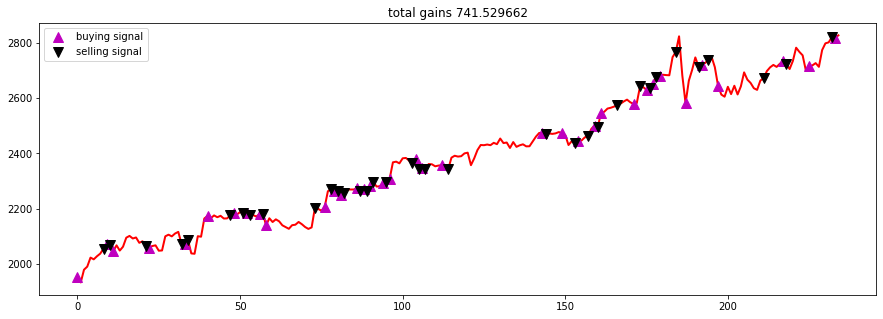

Episode 300, Reward 1961.97, Eval Reward 741.53, Epsilon 0.1000
Loss 0.29
Loss 0.17
Loss 0.60
Loss 0.49
Loss 0.91
Loss 0.65
Evaluate


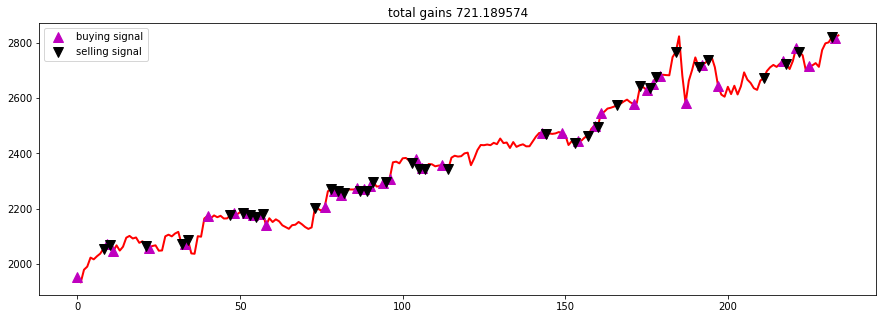

Episode 310, Reward 2201.52, Eval Reward 721.19, Epsilon 0.1000
Loss 1.23
Loss 0.93
Loss 0.67
Loss 0.70
Loss 0.86
Loss 0.29
Evaluate


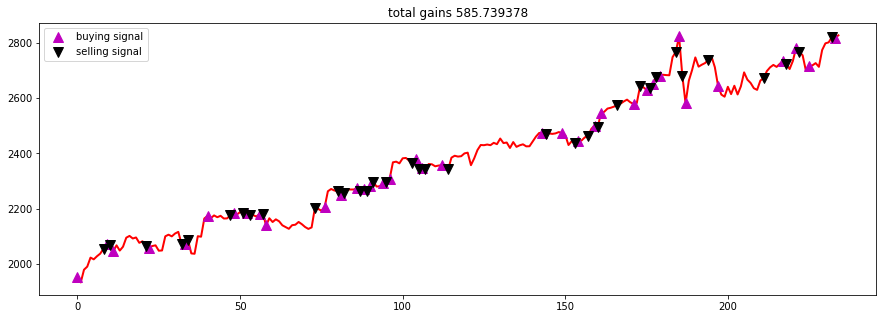

Episode 320, Reward 2195.95, Eval Reward 585.74, Epsilon 0.1000
Loss 0.77
Loss 1.13
Loss 1.00
Loss 0.88
Loss 0.66
Loss 1.25
Evaluate


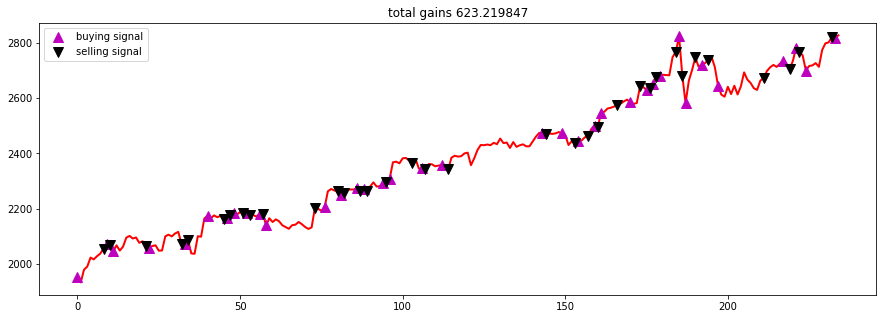

Episode 330, Reward 2024.07, Eval Reward 623.22, Epsilon 0.1000
Loss 0.38
Loss 0.72
Loss 0.89
Loss 1.66
Loss 0.83
Loss 0.52
Evaluate


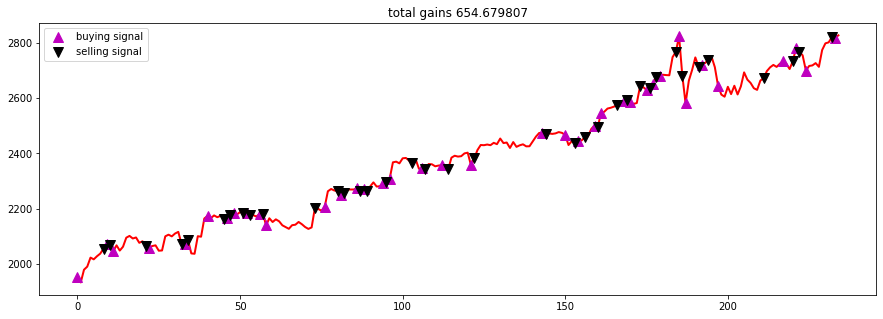

Episode 340, Reward 2173.39, Eval Reward 654.68, Epsilon 0.1000
Loss 0.41
Loss 1.04
Loss 0.25
Loss 0.51
Loss 0.72
Loss 1.33
Evaluate


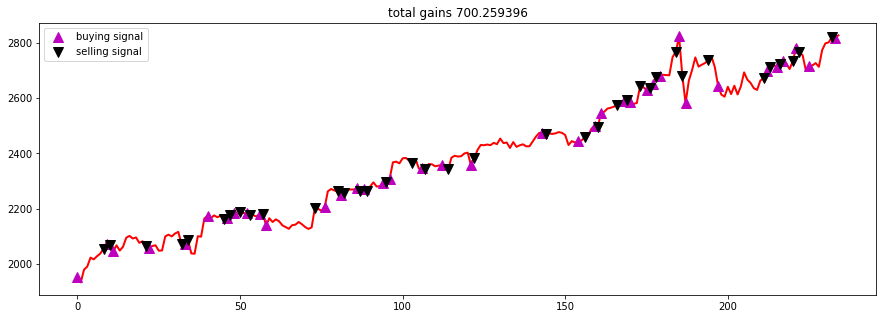

Episode 350, Reward 2155.06, Eval Reward 700.26, Epsilon 0.1000
Loss 0.54
Loss 0.48
Loss 0.56
Loss 0.99
Loss 0.24
Loss 0.51
Evaluate


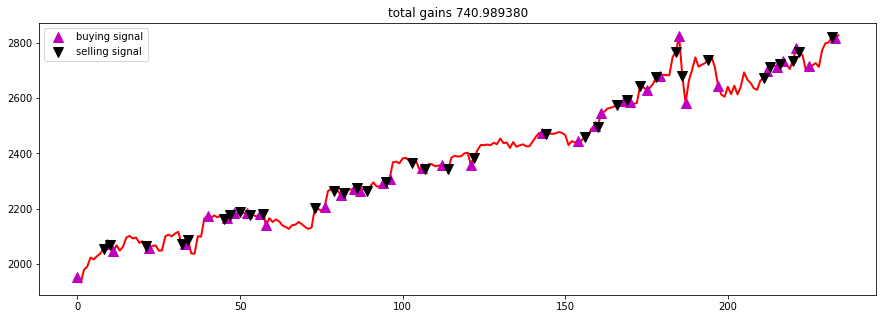

Episode 360, Reward 1813.73, Eval Reward 740.99, Epsilon 0.1000
Loss 1.10
Loss 0.21
Loss 0.68
Loss 0.21
Loss 2.59
Loss 0.34
Evaluate


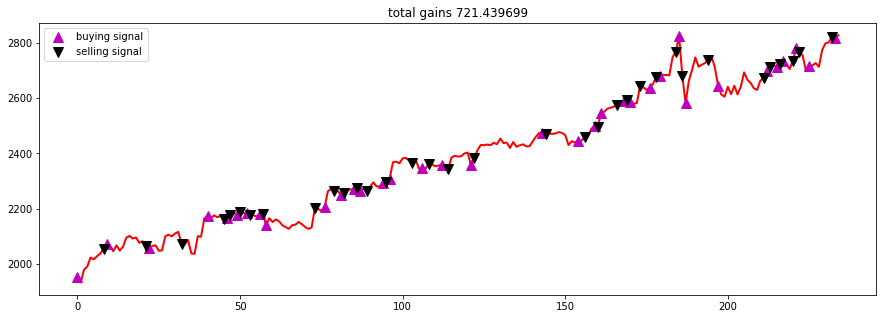

Episode 370, Reward 2100.05, Eval Reward 721.44, Epsilon 0.1000
Loss 0.63
Loss 1.50
Loss 0.40
Loss 0.58
Loss 0.61
Loss 0.34
Evaluate


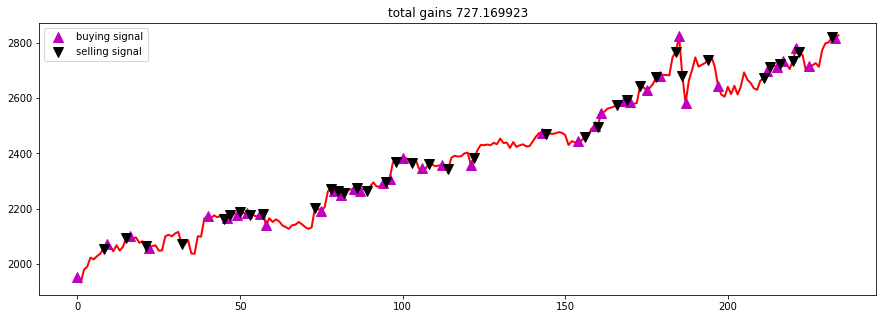

Episode 380, Reward 2030.22, Eval Reward 727.17, Epsilon 0.1000
Loss 0.44
Loss 1.00
Loss 0.29
Loss 0.58
Loss 0.57
Loss 0.65
Evaluate


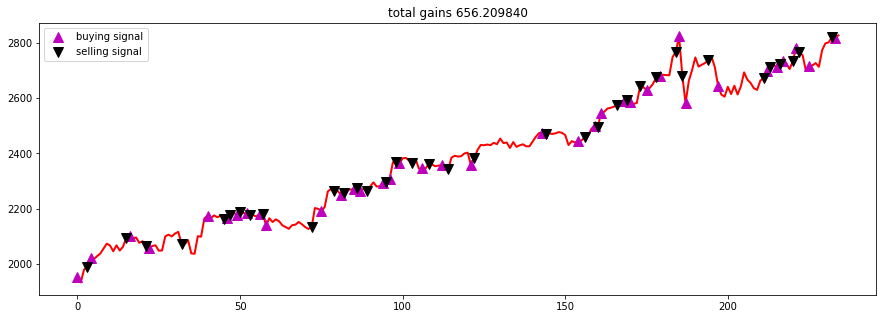

Episode 390, Reward 1902.58, Eval Reward 656.21, Epsilon 0.1000
Loss 1.51
Loss 0.70
Loss 1.46
Loss 0.53
Loss 0.62
Loss 0.28
Evaluate


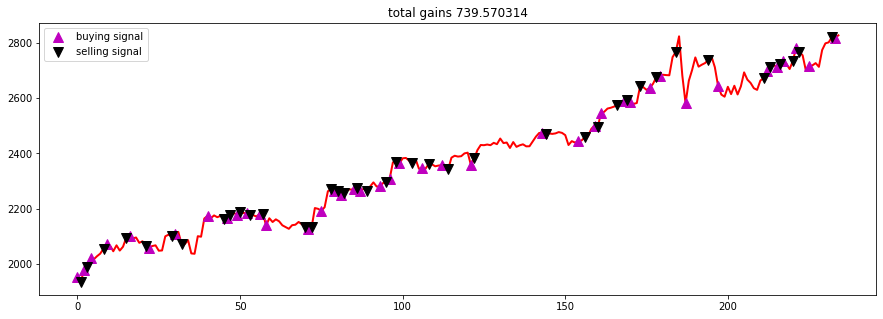

Episode 400, Reward 2082.14, Eval Reward 739.57, Epsilon 0.1000
Loss 0.31
Loss 0.36
Loss 1.15
Loss 0.33
Loss 0.78
Loss 0.21
Evaluate


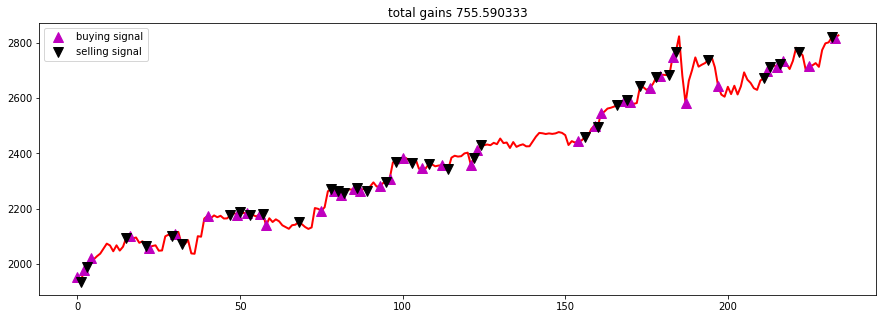

Episode 410, Reward 2143.84, Eval Reward 755.59, Epsilon 0.1000
Loss 0.36
Loss 0.43
Loss 0.38
Loss 0.10
Loss 0.39
Loss 0.13
Evaluate


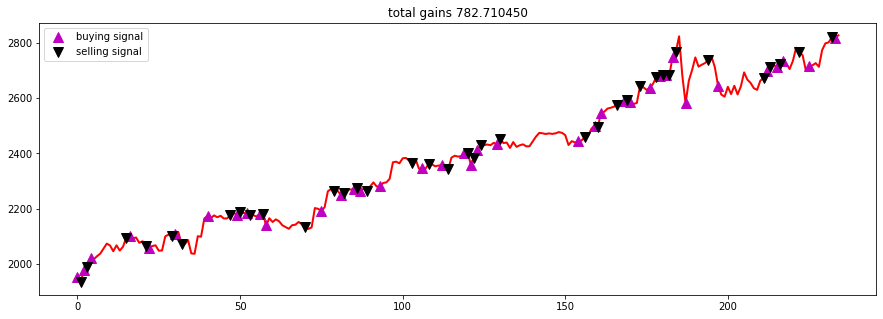

Episode 420, Reward 2236.22, Eval Reward 782.71, Epsilon 0.1000
Loss 0.20
Loss 0.30
Loss 0.43
Loss 1.95
Loss 0.45
Loss 0.40
Evaluate


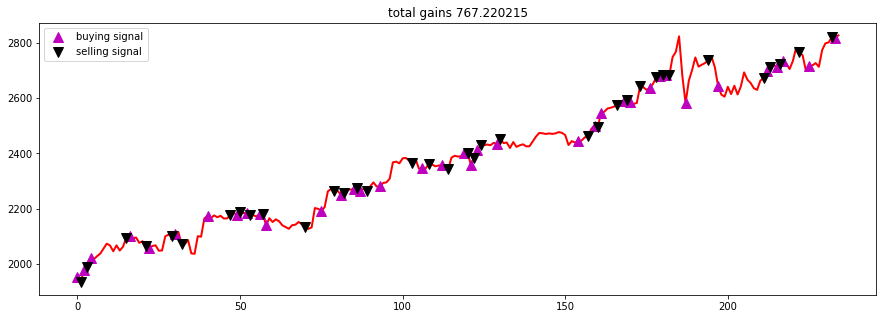

Episode 430, Reward 2237.82, Eval Reward 767.22, Epsilon 0.1000
Loss 0.71
Loss 0.45
Loss 0.52
Loss 0.38
Loss 0.38
Loss 0.22
Evaluate


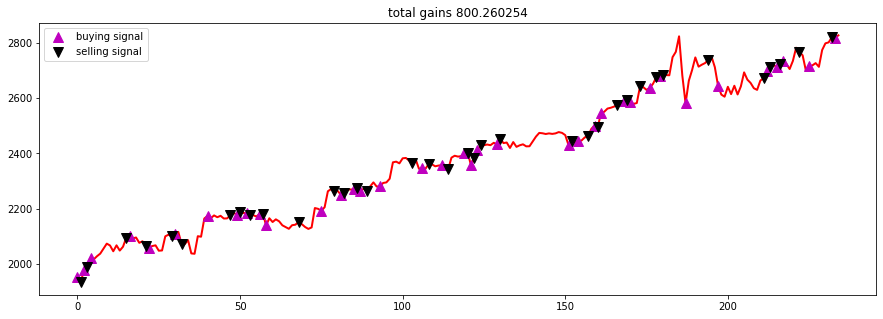

Episode 440, Reward 2132.27, Eval Reward 800.26, Epsilon 0.1000
Loss 0.51
Loss 1.22
Loss 0.49
Loss 0.60
Loss 0.31
Loss 0.33
Evaluate


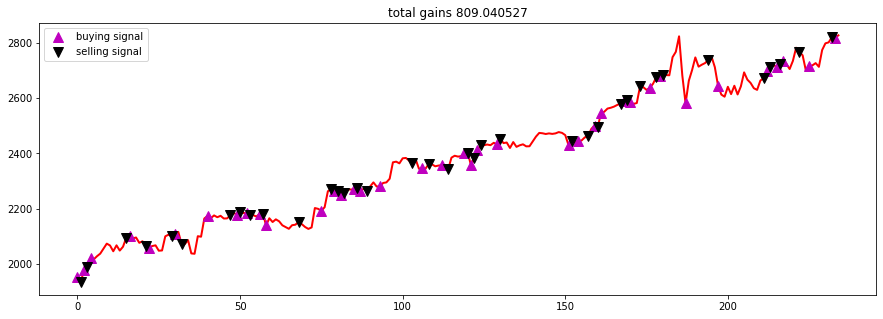

Episode 450, Reward 2138.15, Eval Reward 809.04, Epsilon 0.1000
Loss 0.50
Loss 0.22
Loss 0.35
Loss 0.29
Loss 1.08
Loss 1.05
Evaluate


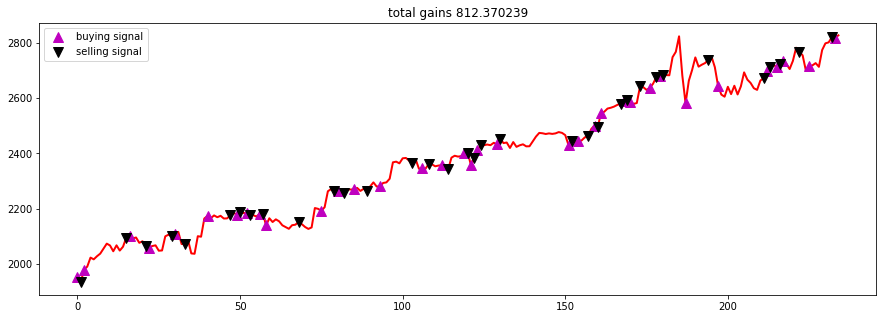

Episode 460, Reward 2063.85, Eval Reward 812.37, Epsilon 0.1000
Loss 0.24
Loss 0.66
Loss 0.26
Loss 0.21
Loss 0.39
Loss 0.09
Evaluate


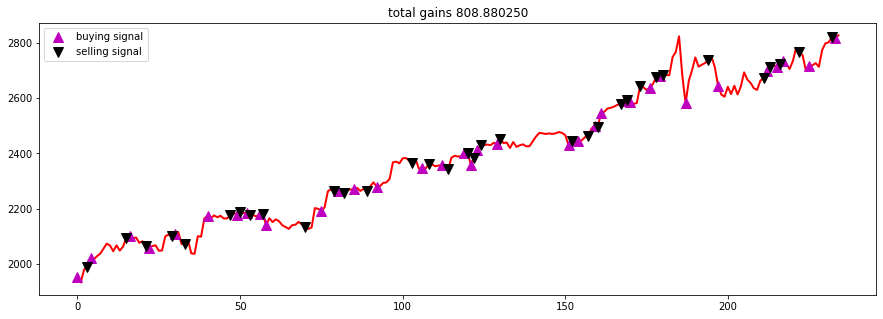

Episode 470, Reward 2109.11, Eval Reward 808.88, Epsilon 0.1000
Loss 0.71
Loss 0.79
Loss 0.57
Loss 0.29
Loss 0.57
Loss 1.19
Evaluate


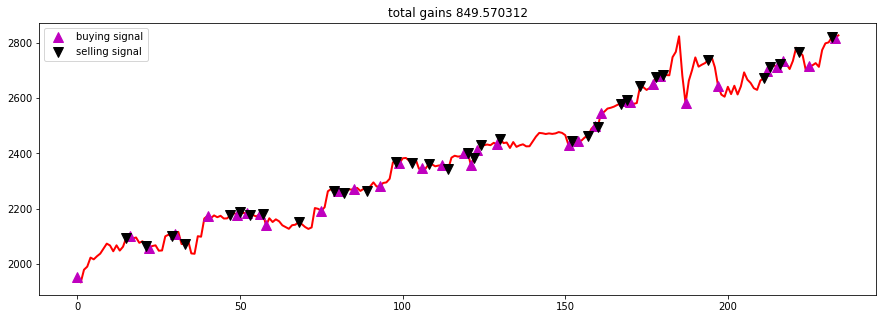

Episode 480, Reward 2077.22, Eval Reward 849.57, Epsilon 0.1000
Loss 1.15
Loss 0.14
Loss 0.25
Loss 0.18
Loss 0.10
Loss 0.31
Evaluate


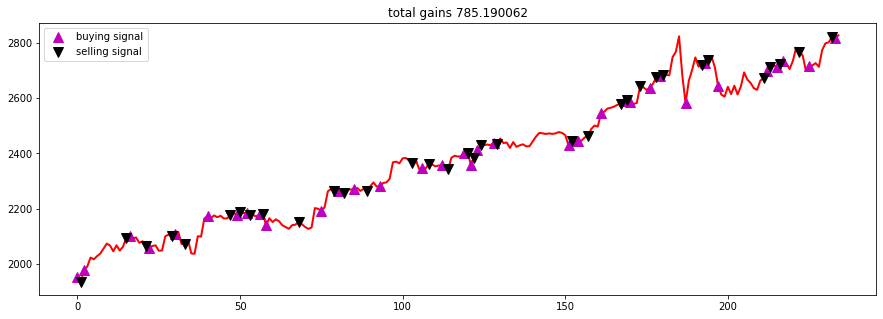

Episode 490, Reward 2241.87, Eval Reward 785.19, Epsilon 0.1000
Loss 0.44
Loss 0.13
Loss 0.27
Loss 0.23
Loss 0.50
Loss 0.16
Evaluate


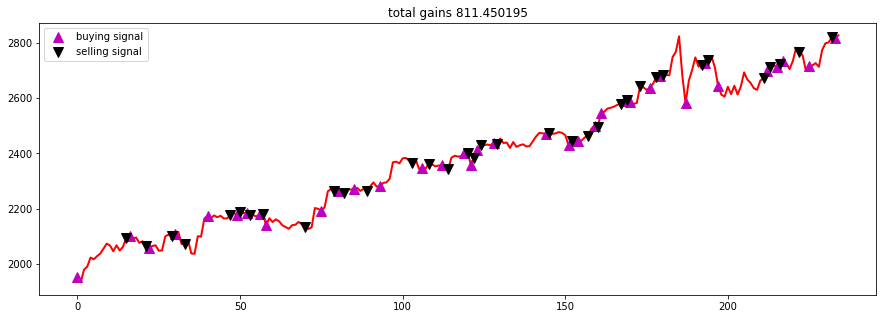

Episode 500, Reward 2173.86, Eval Reward 811.45, Epsilon 0.1000
Loss 0.16
480


In [ ]:
model, saved_model, rewards = train(X_train)

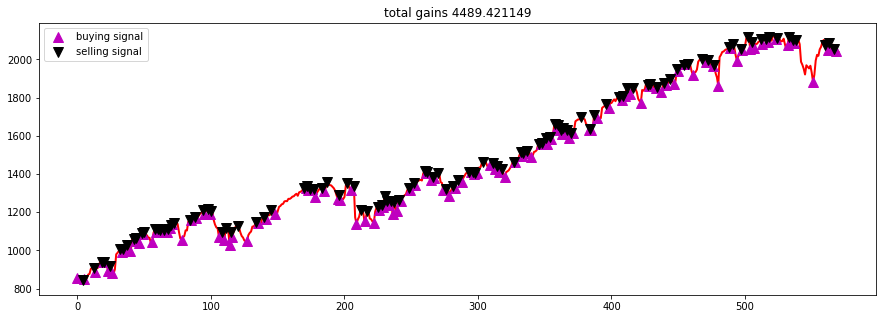

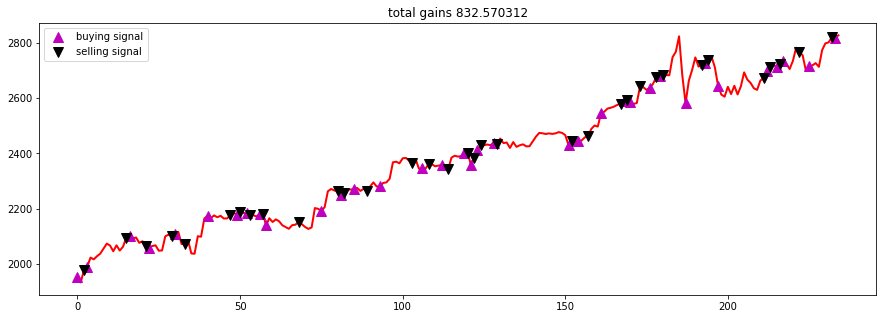

4489.421148999998 832.5703119999998


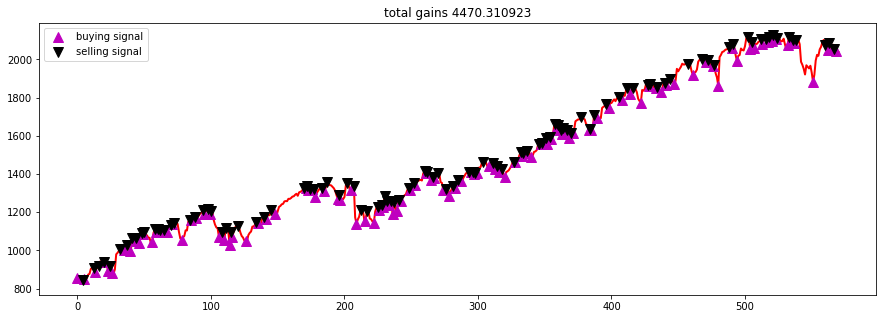

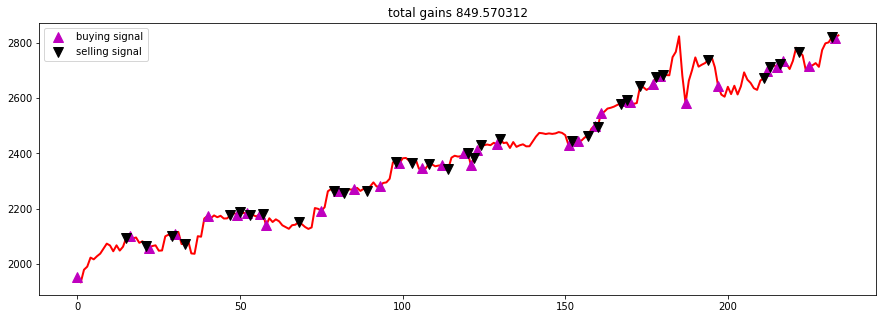

Text(0.5, 0, 'Episodes')

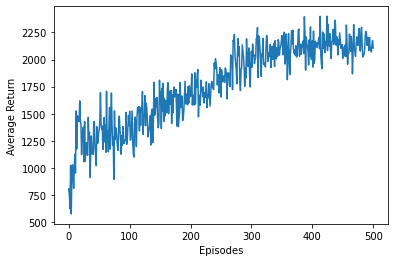

In [ ]:
model.eval()
eval_reward = eval(X_train, price[WINDOW-1:split], model, True)
test_reward = eval(X_test, price[split+WINDOW-1:], model, True)
print(eval_reward, test_reward)
saved_model.eval()
eval_reward = eval(X_train, price[WINDOW-1:split], saved_model, True)
test_reward = eval(X_test, price[split+WINDOW-1:], saved_model, True)

plt.figure()
iterations = range(len(rewards))
plt.plot(iterations, rewards)
plt.ylabel('Average Return')
plt.xlabel('Episodes')

In [ ]:
print(model)

DQN(
  (fc1): Linear(in_features=15, out_features=40, bias=True)
  (lstm): LSTM(40, 40, batch_first=True)
  (fc2): Linear(in_features=40, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=2, bias=True)
)
